#### README

Resources:
1. Tutorial on TimeDistributed layer: [machinelearningmastery blog](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)
2. Hints on [StackOverflow](https://stackoverflow.com/questions/47671732/keras-input-a-3-channel-image-into-lstm) about how to deal with image-LSTMs.

#### Imports and user variables

In [6]:
from __future__ import print_function
%run imports_and_user_variables.py 1000

Imports and variable definitions successful, using 1000 files.


In [1]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils
import IPython
import h5py

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Activation, LSTM, RNN, Concatenate, concatenate, Dropout
from keras import optimizers
from keras.layers import TimeDistributed, Flatten, Reshape
from keras.layers import merge

from __future__ import print_function
from keras.models import Sequential
from keras import layers
from six.moves import range

NUM_FILES = 1000
WINDOW_LENGTH = 4
SEQ_FILE = './pickle_jar/seq_{}_songs_clipped96.h5'.format(NUM_FILES)
MONO_SEQ_FILE = './pickle_jar/mono_seq_{}_songs_clipped96.h5'.format(NUM_FILES)

# Music shape
MIN_PITCH = 13 # C-1
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)

# Don't change unless you know what you're doing
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = BEATS_PER_UNIT * BEAT_RESOLUTION

Using TensorFlow backend.


#### Load dataset

##### Full input datasets

In [4]:
from keras.utils import Sequence

class TimeseriesGeneratorTwoInputs(Sequence):
    """Keras data reading class
    Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            # targets[j] = self.targets[rows[j]] # Comp
            targets[j] = np.clip(self.data1[rows[j]] + self.data2[rows[j]], 0, 1) # Full
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2], targets

In [7]:
# Load dataset
f = h5py.File(SEQ_FILE, 'r')
seq_units_input = f['input_test']
seq_units_comp = f['comp_test']
seq_embed_input = f['input_embed_test']
seq_embed_comp = f['comp_embed_test']
data_gen_train = TimeseriesGeneratorTwoInputs(f['input_train'], f['comp_train'], f['comp_train'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
data_gen_test = TimeseriesGeneratorTwoInputs(f['input_test'], f['comp_test'], f['comp_test'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
print(seq_units_input.shape)
print(seq_units_comp.shape)
print(seq_embed_input.shape)
print(seq_embed_comp.shape)
print(len(data_gen_train))
print(len(data_gen_test))

(23086, 96, 96, 1)
(23086, 96, 96, 1)
(23086, 500)
(23086, 500)
1716
180


##### Monophonic bassline prediction datasets

We use a sequence-to-sequence with teacher forcing, which requires the following datasets:

- `encoder_input_data` is a 3D array of shape `(M, WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1)` containing input units (full units without bass line)
- `decoder_input_data` is a 3D array of shape `(M, NUM_TICKS, NUM_PITCHES)` containing a one-hot vectorization of the bassline pianorolls.
- `decoder_target_data` is the same as `decoder_input_data` but offset by one timestep. ie. `decoder_target_data[:, t, :]` will be the same as `decoder_input_data[:, t + 1, :]`.

In [2]:
from keras.utils import Sequence

class TimeseriesGeneratorThreeInputs_OneHotOutput(Sequence):
    """Keras data reading class
    Utility class for generating batches of temporal data.
    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.
    
    Adapted from the TimeseriesGenerator class:
    https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
    """

    def __init__(self, data1, data2, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data1 = data1
        self.data2 = data2
        assert len(data1) == len(data2)
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data1) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return int(np.ceil(
            (self.end_index - self.start_index + 1) /
            (self.batch_size * self.stride)))

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data1.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:-1]) # Exclude the last channel dimension for OHE targets
        return np.empty(samples_shape), np.empty(samples_shape), np.empty(targets_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)

        samples1, samples2, targets_prev, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples1[j] = self.data1[indices]
            samples2[j] = self.data2[indices]
            
            # Change from (NUM_PITCHES, NUM_TICKS, 1) to (NUM_TICKS, NUM_PITCHES)
            assert len(targets.shape) == 3
            targets_prev[j] = self.targets[rows[j]].swapaxes(0,1).squeeze()
            targets[j,:-1,:] = targets_prev[j,1:,:] # Copy all columns shifted by one
            targets[j,-1,:] = targets_prev[j,-1,:] # Last column remains the same
        if self.reverse:
            return [samples1[:, ::-1, ...], samples2[:, ::-1, ...]], targets
        return [samples1, samples2, targets_prev], targets

In [3]:
# Load dataset
f = h5py.File(MONO_SEQ_FILE, 'r')
seq_units_input = f['input_test']
seq_units_comp = f['bass_test']
data_gen_train = TimeseriesGeneratorThreeInputs_OneHotOutput(f['input_train'], f['bass_train'], f['bass_train'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
data_gen_test = TimeseriesGeneratorThreeInputs_OneHotOutput(f['input_test'], f['bass_test'], f['bass_test'], 
                                              length=WINDOW_LENGTH, sampling_rate=1, batch_size=128, shuffle=True)
print(seq_units_input.shape)
print(seq_units_comp.shape)
print(len(data_gen_train))
print(len(data_gen_test))

(14661, 96, 96, 1)
(14661, 96, 96, 1)
1054
114


## V1: Fully-connected LSTM 

This model skips any convolutional steps, diving straight into LSTM on whole units.

#### Attempt 1
```
recurrent_dim = 800
dense_hidden_dim = 1000
CPU times: user 2h 46s, sys: 1h 4min 33s, total: 3h 5min 19s
Wall time: 2h 10min 1s
Best error: loss: 0.0059 - val_loss: 0.0058 (after 10 epochs)
Time/step: 735s 428ms/step
```
Prediction is quite poor once again, no different from the ghost-notes we were already used to getting previously. Even on training data, predictions are not very strong. Maybe needs more training.

#### Attempt 1 (continued)
```
CPU times: user 2h 1min 59s, sys: 1h 4min 49s, total: 3h 6min 48s
Wall time: 2h 5min 13s
Best error: loss: 0.0037 - val_loss: 0.0061 (after an additional 10 epochs)
Time/step: 750s 437ms/step
```
Now there is clearly overfitting; the training data predictions are perfect, and the test data predictions very poor. BUT, not as poor as it was before!! The notes are less ghost-y now, and looking at the plot it looks believable. But unfortunately upon listening it is clear that the notes are not very right. Hmm but we do know already from the denoising autoencoder that learning harmony and chords is not so difficult when dealing with de-noising. How can we reproduce that kind of results here?

#### Attempt 2
```
Dropout: - 0.3 after hidden layer
         - 0.1 on LSTM1
         - 0.7 on LSTM2
CPU times: user 2h 2min 56s, sys: 1h 4min 38s, total: 3h 7min 35s
Wall time: 2h 5min 3s
Best error: loss: 0.0051 - val_loss: 0.0058 (after 10 epochs)
Time/step: 757s 441ms/step
```
This was actually like shit. Hmmm. Don't use dropout as your magic bullet. Remember that dropout is NOT the same thing as adding noise. Next: Try adding proper noise to the training data..

#### Attempt 3
```
Dropout: - 0.3 after hidden layer
         - 0.1 on LSTM1
         - 0.1 on LSTM2
CPU times: user 2h 36min 7s, sys: 1h 38min 55s, total: 4h 15min 2s
Wall time: 3h 15min 47s
Best error: loss: 0.0060 - val_loss: 0.0121 (after 10 epochs)
Time/step: 1127s 657ms/step
Mean IOU: 0.525428932179
Mean onset score: 0.357185741925567
```
Modified TimeseriesGeneratorTwoInputs so that we aim to predict `full` units instead of `comp` units.

This was actually surprisingly better than the previous attempts! The predicted output is no longer wispy ghost notes, but actual playable notes - except that there are way too many. Also, validation loss plateaus after just the second epoch, then doesn't improve anymore. Training loss continues to get better, easily overfits.

In [13]:
# data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 800
dense_hidden_dim = 1000

# Inputs
input1 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
input2 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
# For each time slice
timeDist1 = TimeDistributed(Flatten())(input1)
timeDist2 = TimeDistributed(Flatten())(input2)
# LSTM
lstm1 = LSTM(recurrent_dim, dropout=0.1)(timeDist1)
lstm2 = LSTM(recurrent_dim, dropout=0.1)(timeDist2)
# Dense
merged = concatenate([lstm1, lstm2])
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
hidden_dropped = Dropout(0.3)(hidden)
# Output
flat_output = Dense(NUM_PITCHES*NUM_TICKS, activation='sigmoid')(hidden_dropped)
output = Reshape((NUM_PITCHES, NUM_TICKS, 1))(flat_output)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 4, 9216)      0           input_5[0][0]                    
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 4, 9216)      0           input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LS

In [14]:
%%time
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/end2end_v1.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
1716/1716 [==============================] - 1369s 798ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 2/10
1716/1716 [==============================] - 1137s 663ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 3/10
1716/1716 [==============================] - 1136s 662ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 4/10
1716/1716 [==============================] - 1133s 660ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 5/10
1716/1716 [==============================] - 1166s 679ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 6/10
1716/1716 [==============================] - 1178s 686ms/step - loss: 0.0074 - val_loss: 0.0118
Epoch 7/10
1716/1716 [==============================] - 1168s 681ms/step - loss: 0.0070 - val_loss: 0.0119
Epoch 8/10
1716/1716 [==============================] - 1174s 684ms/step - loss: 0.0066 - val_loss: 0.0121
Epoch 9/10
1716/1716 [==============================] - 1152s 671ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 10/10
1716/1716 [==============

In [ ]:
MODEL_FILE = './models/end2end_v1.h5'
model = load_model(MODEL_FILE)

## V2: CVAE + LSTM

This model builds directly off of VAE_V7 and RLSTM_V5, simply joining them together to train the whole system at once. Let's see how it goes.

#### Attempt 1
```
Time/step: 1183s 690ms/step
Best error: loss: 0.0104 - val_loss: 0.0118 (after 5 epochs - aborted)
Mean IOU: 0.5256504329
Mean onset score: 0.1143908280778305
```
The metrics don't seem to look any better, but sometimes the music actually sounds quite decent?! I mean, my standards at this point are really low but it performs slightly better on test data than any of the previous models, I think.

In [4]:
def encoder(pianoroll_mat):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    # Encoder stuff
    x = TimeDistributed(Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid'))(pianoroll_mat)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(200, kernel2, strides=kernel2, activation='relu', padding='valid'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(500, kernel3, strides=kernel3, activation='relu', padding='valid'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Flatten())(x)
#     x = TimeDistributed(Dropout(0.1))(x)
#     x = TimeDistributed(Dense(intermediate_dim, activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    return x

def decoder(input_vector):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    x = Reshape((1, 6, 500))(input_vector)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(200, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')(x)
    return x

In [16]:
kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 800
# dense_hidden_dim = 1000

# Inputs
input1 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
input2 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
# For each time slice
timeDist1 = encoder(input1)
timeDist2 = encoder(input2)
# LSTM
lstm1 = LSTM(recurrent_dim, dropout=0.1)(timeDist1)
lstm2 = LSTM(recurrent_dim, dropout=0.1)(timeDist2)
# Dense
merged = concatenate([lstm1, lstm2])
# hidden = Dense(dense_hidden_dim, activation='relu')(merged)
dense_vector = Dense(3000, activation='relu')(merged)
dropped_vector = Dropout(0.3)(dense_vector)
# Output
output = decoder(dropped_vector)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 4, 8, 96, 50) 650         input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_25 (TimeDistri (None, 4, 8, 96, 50) 650         input_4[0][0]                    
__________________________________________________________________________________________________
time_distr

In [125]:
%%time
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/end2end_v2.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Saved Keras model to ./models/end2end_v2.h5
CPU times: user 7.41 s, sys: 225 ms, total: 7.64 s
Wall time: 7.54 s


In [9]:
MODEL_FILE = './models/end2end_v2.h5'
model = load_model(MODEL_FILE)

## V3: CVAE + LSTM

This model builds directly off of VAE_V7 and RLSTM_V5, simply joining them together to train the whole system at once. Let's see how it goes.

#### Attempt 1
```
loss: 0.0092 - val_loss: 0.0115
Saved Keras model to ./models/end2end_v3.h5
CPU times: user 2h 18min 21s, sys: 1h 26min 18s, total: 3h 44min 40s
Wall time: 3h 1min 55s

Mean IOU: 0.520527777778
Mean onset score: 0.14268947096105117
```
The metrics look pretty much identical to the previous attempts. And the output sounds pretty terrible (though after amplification, the pianoroll plot at least doesn't look like ghost town. But notes are all off key and onsets have no regard for their counterpart.

The key observation from observing training and validation loss (and also observed during previous models) is that while training loss does go down, validation loss plateaus pretty quickly. Which makes a lot of sense, but is not encouraging.

Starting to feel like end-to-end is not the way to go.

In [5]:
def encoder(pianoroll_mat):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    # Encoder stuff
    x = TimeDistributed(Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid'))(pianoroll_mat)
    x = TimeDistributed(Conv2D(100, kernel2, strides=kernel2, activation='relu', padding='valid'))(x)
    x = TimeDistributed(Conv2D(200, kernel3, strides=kernel3, activation='relu', padding='valid'))(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(dense_hidden_dim, activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    return x

def decoder(input_vector):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    x = Reshape((1, 6, 200))(input_vector)
    x = Conv2DTranspose(100, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
    x = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
    x = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')(x)
    return x

In [6]:
kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# data_dim = latent_dim # Our model predicts embeddings, so our data is the size of the embedding
recurrent_dim = 20
dense_hidden_dim = 1000

# Inputs
input1 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
input2 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
# For each time slice
timeDist1 = encoder(input1)
timeDist2 = encoder(input2)
# LSTM
lstm1 = LSTM(recurrent_dim)(timeDist1)
lstm2 = LSTM(recurrent_dim)(timeDist2)
# Dense
merged = concatenate([lstm1, lstm2])
hidden = Dense(dense_hidden_dim, activation='relu')(merged)
norm_hidden = BatchNormalization()(hidden)
dense_vector = Dense(1200, activation='relu')(norm_hidden)
norm_dense_vector = BatchNormalization()(dense_vector)
# Output
output = decoder(norm_dense_vector)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='mse', optimizer='rmsprop') #, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 4, 8, 96, 50) 650         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 4, 8, 96, 50) 650         input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [7]:
%%time
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/end2end_v3.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
1716/1716 [==============================] - 1174s 684ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 2/10
1716/1716 [==============================] - 1082s 630ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 3/10
1716/1716 [==============================] - 1079s 629ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 4/10
1716/1716 [==============================] - 1082s 630ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 5/10
1716/1716 [==============================] - 1084s 632ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 6/10
1716/1716 [==============================] - 1084s 631ms/step - loss: 0.0102 - val_loss: 0.0115
Epoch 7/10
1716/1716 [==============================] - 1083s 631ms/step - loss: 0.0099 - val_loss: 0.0114
Epoch 8/10
1716/1716 [==============================] - 1086s 633ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 9/10
1716/1716 [==============================] - 1083s 631ms/step - loss: 0.0094 - val_loss: 0.0115
Epoch 10/10
1716/1716 [==============

In [2]:
MODEL_FILE = './models/end2end_v3.h5'
model = load_model(MODEL_FILE)

## V4: Monophonic RNN encoder-decoder

Based off of the [Keras tutorial for sequence-to-sequence learning](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

The general overview:
1. Use two LSTMs to encode the past input and bass sequences.
2. Merge\* the output states of both LSTMs `[h, c]`, and feed those in as the initial state for the output LSTM.
3. The output LSTM to predicts `output:[...t+1]` given `output:[...t]`. Can think of this as a entirely separate network, except that this LSTM is initialized with the state from the encoder LSTMs.

\* _What's the right way to merge `[h1, c1]` and `[h2, c2]`? Currently using `[h1+h2, c1+c2]` but I have no idea if that even makes any sense at all._

##### Attempt 1
```
Merging output states: mode='sum'
Recurrent dimension: 100
```

In [7]:
def encoder(pianoroll_mat):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    # Encoder stuff
    x = TimeDistributed(Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid'))(pianoroll_mat)
#     x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(200, kernel2, strides=kernel2, activation='relu', padding='valid'))(x)
#     x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(500, kernel3, strides=kernel3, activation='relu', padding='valid'))(x)
#     x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(BatchNormalization())(x)
    return x

def decoder(input_vector):
    kernel1 = (12, 1)
    kernel2 = (8, 4)
    kernel3 = (1, 4)
    x = Reshape((1, 6, 500))(input_vector)
#     x = BatchNormalization()(x)
    x = Conv2DTranspose(200, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
#     x = BatchNormalization()(x)
    x = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
#     x = BatchNormalization()(x)
    x = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')(x)
    return x

In [10]:
kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)

recurrent_dim = 100 # This is the latent dimension of the LSTM that will be passed
num_decoder_tokens = NUM_PITCHES # 96-dimensional one-hot encodings

#------------------- ENCODER

# Inputs
input1 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
input2 = Input(shape=(WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1))
# For each time slice
timeDist1 = encoder(input1)
timeDist2 = encoder(input2)
# LSTM - we discard the predicted output, we're only interested in the states
_, state_h_1, state_c_1 = LSTM(recurrent_dim, return_state=True)(timeDist1)
_, state_h_2, state_c_2 = LSTM(recurrent_dim, return_state=True)(timeDist2)
# Merge states to feed into decoder LSTM
state_h = merge([state_h_1, state_h_2], mode='sum')
state_c = merge([state_c_1, state_c_2], mode='sum')
encoder_states = [state_h, state_c]

#------------------- DECODER

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(recurrent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([input1, input2, decoder_inputs], decoder_outputs)
# Compile
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4, 96, 96, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 4, 8, 96, 50) 650         input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_16 (TimeDistri (None, 4, 8, 96, 50) 650         input_5[0][0]                    
__________________________________________________________________________________________________
time_distr

In [11]:
%%time
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems

model.fit_generator(generator=data_gen_train,
                    steps_per_epoch=len(data_gen_train),#/batch_size,
                    epochs=10,
                    validation_data=data_gen_test)

MODEL_FILE = './models/end2end_RNNdecoder_v1.h5'
model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Epoch 1/10
1054/1054 [==============================] - 550s 521ms/step - loss: 0.6294 - val_loss: 0.3785
Epoch 2/10
1054/1054 [==============================] - 540s 512ms/step - loss: 0.3344 - val_loss: 0.3616
Epoch 3/10
1054/1054 [==============================] - 535s 507ms/step - loss: 0.3090 - val_loss: 0.3537
Epoch 4/10
1054/1054 [==============================] - 532s 505ms/step - loss: 0.2916 - val_loss: 0.3410
Epoch 5/10
1054/1054 [==============================] - 556s 528ms/step - loss: 0.2769 - val_loss: 0.3389
Epoch 6/10
1054/1054 [==============================] - 550s 522ms/step - loss: 0.2687 - val_loss: 0.3299
Epoch 7/10
1054/1054 [==============================] - 557s 528ms/step - loss: 0.2606 - val_loss: 0.3290
Epoch 8/10
1054/1054 [==============================] - 559s 531ms/step - loss: 0.2534 - val_loss: 0.3327
Epoch 9/10
1054/1054 [==============================] - 554s 525ms/step - loss: 0.2479 - val_loss: 0.3338
Epoch 10/10
1054/1054 [=======================

In [4]:
MODEL_FILE = './models/end2end_RNNdecoder_v1.h5'
model = load_model(MODEL_FILE)

### Inference

In [12]:
# Encoder returns the merged LSTM states
encoder_model = Model([input1, input2], encoder_states)

MODEL_FILE = './models/end2end_RNNdecoder_v1_encoder.h5'
encoder_model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

# Decoder takes in two inputs, state_h and state_c from the encoder
# and initializes the output LSTM to 
decoder_state_input_h = Input(shape=(recurrent_dim,))
decoder_state_input_c = Input(shape=(recurrent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, # Input: Concatenated [target_prev, encoder_h, encoder_c]
    [decoder_outputs] + decoder_states) # Output: Concatenated [target, decoder_h, decoder_c]

MODEL_FILE = './models/end2end_RNNdecoder_v1_decoder.h5'
decoder_model.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Saved Keras model to ./models/end2end_RNNdecoder_v1_encoder.h5
Saved Keras model to ./models/end2end_RNNdecoder_v1_decoder.h5


In [5]:
MODEL_FILE = './models/end2end_RNNdecoder_v1_encoder.h5'
encoder_model = load_model(MODEL_FILE)

MODEL_FILE = './models/end2end_RNNdecoder_v1_decoder.h5'
decoder_model = load_model(MODEL_FILE)

# Results and Evaluation

Use the models trained above to predict an accompanying sequence.

#### Tick-by-tick inference from RNN

In [62]:
num_decoder_tokens = NUM_PITCHES

def decode_sequence(input_seq_pair):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq_pair)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    # Populate the first character of target sequence with the start token.
    start_token = np.zeros(num_decoder_tokens)
    start_token[-1] = 1 # Start token is [...,0,0,0,1]
    target_seq[0, 0, :] = start_token

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    output_onehotmatrix = np.zeros((NUM_TICKS, num_decoder_tokens))
    output_onehotmatrix[0] = start_token
    for i in range(1,NUM_TICKS):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = np.zeros(num_decoder_tokens)
        sampled_token[sampled_token_index] = 1 # One hot encoding
        # Write to output
        output_onehotmatrix[i] = sampled_token

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    assert np.all(np.sum(output_onehotmatrix, axis=1) == 1) # Each tick is a one-hot encoded vector
    output_pianoroll = pianoroll_utils.one_hot_to_pianoroll(output_onehotmatrix) 
    assert output_pianoroll.shape == (NUM_PITCHES, NUM_TICKS)
    return output_pianoroll

#### Predict and plot

In [16]:
NUM_PREDICTIONS = 8
NUM_UNITS = WINDOW_LENGTH + NUM_PREDICTIONS
# Grab a random sequence of embeddings as input
unit_index = np.random.randint(seq_units_comp.shape[0] - NUM_UNITS)

# Predict NUM_PREDICTIONS embeddings
predicted_comp_units = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1)) #seq_units_comp[unit_index:unit_index + WINDOW_LENGTH].copy()
for i, _ in enumerate(range(NUM_PREDICTIONS)):
    input1 = np.array([
        seq_units_input[unit_index + i : unit_index + WINDOW_LENGTH + i]
    ])
    input2 = np.array([
        predicted_comp_units[-WINDOW_LENGTH:] # The WINDOW_LENGTH latest units
    ])
    # Predict new unit
    y_comp = model.predict([input1,input2]) # Standard predictor
#     y_comp = decode_sequence([input1,input2]) # RNN Decoder
    
    # Remove input pitches from the prediction
    input1_concat = np.concatenate(input1.squeeze(), axis=1)
    input_pitches = pianoroll_utils.get_active_pitches(input1_concat, MIN_PITCH, MAX_PITCH)
    y_comp = pianoroll_utils.mask_pitches(y_comp.squeeze(), input_pitches, MIN_PITCH, MAX_PITCH)
    y_comp = y_comp[np.newaxis, ..., np.newaxis]

    # Append predicted unit
    predicted_comp_units = np.concatenate([predicted_comp_units, y_comp], axis=0)
    
    # Get nearest neighbor
#     knn_index = knn_model.kneighbors(y_comp_embed, return_distance = False)[0][0]
#     sample_knn = knn_units[knn_index].squeeze()[np.newaxis, ...]
#     knn_comp = np.concatenate([knn_comp, sample_knn], axis=0)

# knn_comp = np.concatenate(knn_comp, axis=1)
print(predicted_comp_units.shape)
# print(knn_comp.shape)

(12, 96, 96, 1)


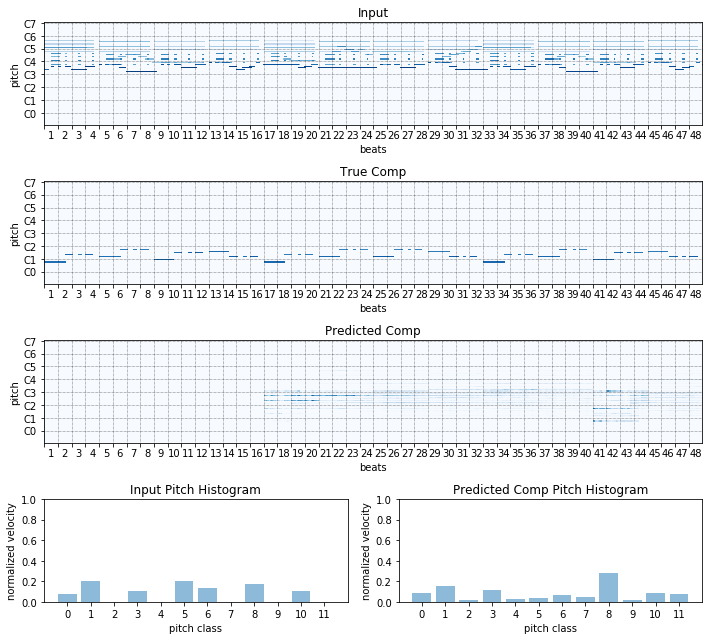

In [37]:
# Concatenate units into one long pianoroll
predicted_comp = np.concatenate(predicted_comp_units, axis=1).squeeze()
# predicted_comp = (predicted_comp * 1.5).clip(0,1)
# predicted_comp = pianoroll_utils.pianoroll_preprocess(predicted_comp, MIN_PITCH, MAX_PITCH)
model_input = np.concatenate(seq_units_input[unit_index:unit_index + NUM_UNITS], axis=1).squeeze()
model_comp = np.concatenate(seq_units_comp[unit_index:unit_index + NUM_UNITS], axis=1).squeeze()

# Plot comparison
# fig, ax = plt.subplots(3,1)

rows = 4
cols = 2
fig = plt.figure()
fig.set_size_inches(10, 9, forward=True)

ax1 = plt.subplot2grid((rows, cols), (0, 0), fig=fig, colspan=2)
ax2 = plt.subplot2grid((rows, cols), (1, 0), fig=fig, colspan=2)
ax3 = plt.subplot2grid((rows, cols), (2, 0), fig=fig, colspan=2)
ax4 = plt.subplot2grid((rows, cols), (3, 0), fig=fig)
ax5 = plt.subplot2grid((rows, cols), (3, 1), fig=fig)

ax1.set_title('Input')
ax2.set_title('True Comp')
ax3.set_title('Predicted Comp')
ax4.set_title('Input Pitch Histogram')
ax5.set_title('Predicted Comp Pitch Histogram')

pianoroll_utils.plot_pianoroll(ax1, model_input, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='Blues')
pianoroll_utils.plot_pianoroll(ax2, model_comp, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='Blues')
pianoroll_utils.plot_pianoroll(ax3, predicted_comp, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='Blues')
# pianoroll_utils.plot_pianoroll(ax[4], knn_comp, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='Blues')
pianoroll_utils.plot_pitch_class_histogram(ax4, K.eval(custom_loss.get_pitch_class_histogram(model_input[np.newaxis,...,np.newaxis]))[0])
pianoroll_utils.plot_pitch_class_histogram(ax5, K.eval(custom_loss.get_pitch_class_histogram(predicted_comp[np.newaxis,...,np.newaxis]))[0])
fig.tight_layout()
plt.savefig('fig/end2end_CRNN.eps', format='eps', dpi=1000)

# print(pianoroll_utils.get_active_pitch_classes(model_input, MIN_PITCH, MAX_PITCH))
# print(pianoroll_utils.get_active_pitch_classes(predicted_comp, MIN_PITCH, MAX_PITCH))
# print(pianoroll_utils.pitch_intersection_over_union(model_input, predicted_comp, MIN_PITCH, MAX_PITCH))
# print(pianoroll_utils.score_note_onsets(predicted_comp, MIN_PITCH, MAX_PITCH, num_units=NUM_UNITS))

# Listen to the MIDI files
# pianoroll_utils.play_pianoroll(model_input, MIN_PITCH, MAX_PITCH, 'ori')
# pianoroll_utils.play_pianoroll(model_comp, MIN_PITCH, MAX_PITCH, '0')
# pianoroll_utils.play_pianoroll(predicted_comp, MIN_PITCH, MAX_PITCH, '1')
# pianoroll_utils.play_pianoroll(knn_comp, MIN_PITCH, MAX_PITCH, '3')
# pianoroll_utils.play_pianoroll( (model_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '4')
# pianoroll_utils.play_pianoroll( (predicted_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '5')
# pianoroll_utils.play_pianoroll( (knn_comp + model_input).clip(0,1), MIN_PITCH, MAX_PITCH, '7')

#### Evaluate key and rhythmic qualities.

In [7]:
%%time
NUM_TESTS = 100
NUM_PREDICTIONS = 12
NUM_UNITS = WINDOW_LENGTH + NUM_PREDICTIONS

total_iou = 0
total_onset_score = 0

for i in range(NUM_TESTS):
    # Grab a random sequence of embeddings as input
    unit_index = np.random.randint(seq_units_comp.shape[0] - NUM_UNITS)

    # Predict NUM_PREDICTIONS embeddings
    predicted_comp_units = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS, 1)) #seq_units_comp[unit_index:unit_index + WINDOW_LENGTH].copy()
    # knn_comp = np.zeros((WINDOW_LENGTH, NUM_PITCHES, NUM_TICKS))
    for i, _ in enumerate(range(NUM_PREDICTIONS)):
        input1 = np.array([
            seq_units_input[unit_index + i : unit_index + WINDOW_LENGTH + i]
        ])
        input2 = np.array([
            predicted_comp_units[-WINDOW_LENGTH:] # The WINDOW_LENGTH latest units
        ])
        # Predict new embedding
        y_comp = model.predict([input1,input2])

        # Remove input pitches from the prediction
        input1_concat = np.concatenate(input1.squeeze(), axis=1)
        input_pitches = pianoroll_utils.get_active_pitches(input1_concat, MIN_PITCH, MAX_PITCH)
        y_comp = pianoroll_utils.mask_pitches(y_comp.squeeze(), input_pitches, MIN_PITCH, MAX_PITCH)
        y_comp = y_comp[np.newaxis, ..., np.newaxis]

        # Append predicted embedding
        predicted_comp_units = np.concatenate([predicted_comp_units, y_comp], axis=0)

    # Concatenate units into one long pianoroll
    predicted_comp = np.concatenate(predicted_comp_units, axis=1).squeeze()
    predicted_comp = pianoroll_utils.pianoroll_preprocess(predicted_comp, MIN_PITCH, MAX_PITCH)
    model_input = np.concatenate(seq_units_input[unit_index:unit_index + NUM_UNITS], axis=1).squeeze()

    # Get metrics
    iou = pianoroll_utils.pitch_intersection_over_union(predicted_comp, model_input, MIN_PITCH, MAX_PITCH)
    onset_score = pianoroll_utils.score_note_onsets(predicted_comp, MIN_PITCH, MAX_PITCH, num_units=NUM_UNITS)
    total_iou += iou
    total_onset_score += onset_score

mean_iou = total_iou / NUM_TESTS
mean_onset_score = total_onset_score / NUM_TESTS
print("Mean IOU:", mean_iou)
print("Mean onset score:", mean_onset_score)

Mean IOU: 0.520527777778
Mean onset score: 0.14268947096105117
CPU times: user 16.8 s, sys: 3.33 s, total: 20.1 s
Wall time: 14.4 s
